<a href="https://colab.research.google.com/github/swarajaalla/Infy_SB_AirFly_Insights/blob/sravani_dev/DV_Airlines_Insights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# -----------------------
# STEP 0: Install required packages
# -----------------------
!pip install -q plotly folium python-pptx img2pdf

# Common libs
# seaborn, matplotlib, pandas, numpy are typically preinstalled in Colab.


In [10]:
# -----------------------
# STEP 1: Imports & helper functions
# -----------------------
import os, zipfile, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
from folium.plugins import HeatMap
import img2pdf
from pptx import Presentation
from pptx.util import Inches

sns.set(style="whitegrid")
pd.set_option('display.max_columns', 200)
os.makedirs('outputs', exist_ok=True)

# Helper: robust column finder (searches for substring matches)
def pick_col(df, keywords):
    """Return first column name in df that contains any of the keywords (case-insensitive)."""
    cols = df.columns.tolist()
    for kw in keywords:
        for c in cols:
            if kw.lower() in c.lower():
                return c
    return None

# Helper: save a matplotlib figure
def savefig(fig, name, dpi=150):
    path = os.path.join('outputs', name)
    fig.savefig(path, bbox_inches='tight', dpi=dpi)
    print("Saved:", path)
    return path


In [11]:
# -----------------------
# STEP 2: Load dataset (from common paths or upload)
# -----------------------
# Try common file paths first
possible_paths = [
    '/content/flights_sample_100k.csv.zip',
    '/content/flights_sample_100k.csv'
]

zip_path = None
for p in possible_paths:
    if os.path.exists(p):
        zip_path = p
        break

if zip_path is None:
    # If running in Colab, ask user to upload
    try:
        from google.colab import files
        print("Please upload the dataset zip (flights_sample_100k.csv.zip) when prompted.")
        uploaded = files.upload()
        # take the first uploaded file
        zip_path = list(uploaded.keys())[0]
    except Exception as e:
        raise RuntimeError("No dataset found. Upload `flights_sample_100k.csv.zip` to Colab or place it at /content.") from e

# Try to read CSV inside zip (handles zipped single-csv)
df = None
try:
    # If pandas supports reading the zip directly
    df = pd.read_csv(zip_path, compression='zip', low_memory=False)
except Exception:
    # Fallback: open zip and read first csv entry
    with zipfile.ZipFile(zip_path) as z:
        candidate = [n for n in z.namelist() if n.lower().endswith('.csv')]
        if not candidate:
            raise RuntimeError("Zip archive did not contain a CSV file.")
        with z.open(candidate[0]) as f:
            df = pd.read_csv(f, low_memory=False)

print("Loaded dataset with shape:", df.shape)
df.head().T.iloc[:30]  # show first rows (transposed, first 30 cols)


Loaded dataset with shape: (100000, 32)


,0,1,2,3,4
FL_DATE,2019-03-01,2021-02-16,2022-04-12,2021-10-13,2022-06-05
AIRLINE,Allegiant Air,American Airlines Inc.,PSA Airlines Inc.,Southwest Airlines Co.,Southwest Airlines Co.
AIRLINE_DOT,Allegiant Air: G4,American Airlines Inc.: AA,PSA Airlines Inc.: OH,Southwest Airlines Co.: WN,Southwest Airlines Co.: WN
AIRLINE_CODE,G4,AA,OH,WN,WN
DOT_CODE,20368,19805,20397,19393,19393
FL_NUMBER,1668,2437,5560,1944,3081
ORIGIN,PGD,DFW,EWN,ABQ,PIT
ORIGIN_CITY,"Punta Gorda, FL","Dallas/Fort Worth, TX","New Bern/Morehead/Beaufort, NC","Albuquerque, NM","Pittsburgh, PA"
DEST,SPI,LAX,CLT,DEN,STL
DEST_CITY,"Springfield, IL","Los Angeles, CA","Charlotte, NC","Denver, CO","St. Louis, MO"


No charts were generated by quickchart


In [12]:
# -----------------------
# STEP 3: Quick data profiling
# -----------------------
print("Columns:", df.columns.tolist())
print("\nNulls per column (top 30):\n", df.isna().sum().sort_values(ascending=False).head(30))
print("\nDtypes:\n", df.dtypes.value_counts())

# Basic numeric summaries
display(df.describe(include='all').T.loc[:, ['count','unique','top','freq','mean','std','min','max']].head(30))


Columns: ['FL_DATE', 'AIRLINE', 'AIRLINE_DOT', 'AIRLINE_CODE', 'DOT_CODE', 'FL_NUMBER', 'ORIGIN', 'ORIGIN_CITY', 'DEST', 'DEST_CITY', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT']

Nulls per column (top 30):
 CANCELLATION_CODE          97373
DELAY_DUE_LATE_AIRCRAFT    82008
DELAY_DUE_CARRIER          82008
DELAY_DUE_SECURITY         82008
DELAY_DUE_NAS              82008
DELAY_DUE_WEATHER          82008
ARR_DELAY                   2852
ELAPSED_TIME                2852
AIR_TIME                    2852
WHEELS_ON                   2655
ARR_TIME                    2655
TAXI_IN                     2655
WHEELS_OFF                  2618
TAXI_OUT                    2618
DEP_DELAY                   2

,count,unique,top,freq,mean,std,min,max
FL_DATE,100000,1704,2020-01-31,98,NaN,NaN,NaN,NaN
AIRLINE,100000,18,Southwest Airlines Co.,19150,NaN,NaN,NaN,NaN
AIRLINE_DOT,100000,18,Southwest Airlines Co.: WN,19150,NaN,NaN,NaN,NaN
AIRLINE_CODE,100000,18,WN,19150,NaN,NaN,NaN,NaN
DOT_CODE,100000.0,NaN,NaN,NaN,19977.25777,377.223161,19393.0,20452.0
FL_NUMBER,100000.0,NaN,NaN,NaN,2511.91066,1745.63292,1.0,8819.0
ORIGIN,100000,372,ATL,5099,NaN,NaN,NaN,NaN
ORIGIN_CITY,100000,366,"Chicago, IL",5219,NaN,NaN,NaN,NaN
DEST,100000,376,ATL,5095,NaN,NaN,NaN,NaN
DEST_CITY,100000,369,"Chicago, IL",5359,NaN,NaN,NaN,NaN


In [13]:
# -----------------------
# STEP 4: Cleaning & Feature Engineering
# - normalize column names, parse datetime, create route, delayed flags, aggregate delay causes
# -----------------------
# Normalize column names to remove odd spaces but keep originals for reference
df.columns = [c.strip() for c in df.columns]

# Find common column names (robustly)
col_year = pick_col(df, ['year'])
col_month = pick_col(df, ['month'])
col_day = pick_col(df, ['dayofmonth','day'])
col_crs_dep = pick_col(df, ['crsdeptime','crs_dep','scheduled_dep','crs_dep_time','crsdeptime'])
col_dep_delay = pick_col(df, ['depdelay','departuredelay','dep_delay'])
col_arr_delay = pick_col(df, ['arrdelay','arrivaldelay','arr_delay'])
col_origin = pick_col(df, ['origin','org','from'])
col_dest = pick_col(df, ['dest','destination','to'])
col_airline = pick_col(df, ['airline','carrier','uniquecarrier','operatingcarrier'])
col_cancelled = pick_col(df, ['cancelled','canceled'])
col_cancel_code = pick_col(df, ['cancellationcode','cancelcode','cancellation_code'])

print("Detected columns -> year:", col_year, "month:", col_month, "day:", col_day,
      "\ncrs_dep:", col_crs_dep, "dep_delay:", col_dep_delay, "arr_delay:", col_arr_delay,
      "\norigin:", col_origin, "dest:", col_dest, "airline:", col_airline,
      "\ncancelled:", col_cancelled, "cancel_code:", col_cancel_code)

# Parse scheduled departure datetime if possible
if col_year and col_month and col_day and col_crs_dep:
    # Create consistent integer time strings like "0130" -> 01:30
    df[col_crs_dep] = df[col_crs_dep].fillna(0)
    # some datasets store times as floats; convert carefully
    df[col_crs_dep] = df[col_crs_dep].astype(int).astype(str).str.zfill(4)
    hrs = df[col_crs_dep].str[:2].astype(int)
    mins = df[col_crs_dep].str[2:].astype(int)
    dates = pd.to_datetime(dict(year=df[col_year].astype(int),
                                month=df[col_month].astype(int),
                                day=df[col_day].astype(int)))
    df['scheduled_dep'] = dates + pd.to_timedelta(hrs, unit='h') + pd.to_timedelta(mins, unit='m')
    df['dep_hour'] = df['scheduled_dep'].dt.hour
    df['day_of_week'] = df['scheduled_dep'].dt.day_name()
    df['month_name'] = df['scheduled_dep'].dt.month_name()
    print("Created scheduled_dep, dep_hour, day_of_week, month_name")
else:
    print("Could not parse scheduled_dep (missing required columns).")

# Normalize numeric delay columns
for c in [col_dep_delay, col_arr_delay]:
    if c:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Create unified airline & route
if col_airline:
    df['airline_name'] = df[col_airline].astype(str)
if col_origin and col_dest:
    df['route'] = df[col_origin].astype(str) + "-" + df[col_dest].astype(str)

# is_delayed flag (threshold 15 minutes)
if col_arr_delay or col_dep_delay:
    arr = df[col_arr_delay] if col_arr_delay in df.columns else pd.Series(np.nan, index=df.index)
    dep = df[col_dep_delay] if col_dep_delay in df.columns else pd.Series(np.nan, index=df.index)
    df['is_delayed_15m'] = ((arr > 15) | (dep > 15)).fillna(False)

# Aggregate delay causes if columns exist
possible_causes = ['carrierdelay','weatherdelay','nasdelay','securitydelay','lateaircraftdelay',
                   'carrier_delay','weather_delay','nas_delay','security_delay','late_aircraft_delay']
delay_cause_cols = [c for c in df.columns if any(pc in c.lower() for pc in possible_causes)]
print("Detected delay-cause columns:", delay_cause_cols)

if delay_cause_cols:
    # ensure numeric
    for c in delay_cause_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)
    df['total_reported_cause_delay'] = df[delay_cause_cols].sum(axis=1)
    # major cause per flight
    def major_cause(row):
        vals = row[delay_cause_cols]
        if vals.sum() <= 0:
            return 'none'
        return vals.idxmax()
    df['major_delay_cause'] = df.apply(major_cause, axis=1)
else:
    print("No per-cause delay columns found in dataset.")

# Cancellation mapping if present
if col_cancelled:
    df[col_cancelled] = pd.to_numeric(df[col_cancelled], errors='coerce').fillna(0).astype(int)
    if col_cancel_code:
        # map ANSI codes A,B,C,D if present
        mapping = {'A':'Carrier','B':'Weather','C':'NAS','D':'Security'}
        df['cancellation_reason'] = df[col_cancel_code].map(mapping).fillna(df[col_cancel_code])
    else:
        df['cancellation_reason'] = df[col_cancelled].apply(lambda x: 'Cancelled' if x==1 else 'NotCancelled')

# peek cleaned frame
print("After FE shape:", df.shape)
df.head().T.iloc[:30]


Detected columns -> year: None month: None day: None 
crs_dep: CRS_DEP_TIME dep_delay: DEP_DELAY arr_delay: ARR_DELAY 
origin: ORIGIN dest: DEST airline: AIRLINE 
cancelled: CANCELLED cancel_code: CANCELLATION_CODE
Could not parse scheduled_dep (missing required columns).
Detected delay-cause columns: []
No per-cause delay columns found in dataset.
After FE shape: (100000, 36)


,0,1,2,3,4
FL_DATE,2019-03-01,2021-02-16,2022-04-12,2021-10-13,2022-06-05
AIRLINE,Allegiant Air,American Airlines Inc.,PSA Airlines Inc.,Southwest Airlines Co.,Southwest Airlines Co.
AIRLINE_DOT,Allegiant Air: G4,American Airlines Inc.: AA,PSA Airlines Inc.: OH,Southwest Airlines Co.: WN,Southwest Airlines Co.: WN
AIRLINE_CODE,G4,AA,OH,WN,WN
DOT_CODE,20368,19805,20397,19393,19393
FL_NUMBER,1668,2437,5560,1944,3081
ORIGIN,PGD,DFW,EWN,ABQ,PIT
ORIGIN_CITY,"Punta Gorda, FL","Dallas/Fort Worth, TX","New Bern/Morehead/Beaufort, NC","Albuquerque, NM","Pittsburgh, PA"
DEST,SPI,LAX,CLT,DEN,STL
DEST_CITY,"Springfield, IL","Los Angeles, CA","Charlotte, NC","Denver, CO","St. Louis, MO"


In [14]:
# -----------------------
# STEP 5: Save cleaned dataset for reuse (parquet compressed)
# -----------------------
clean_path = 'outputs/cleaned_flights.parquet'
df.to_parquet(clean_path, index=False)
print("Cleaned data saved to", clean_path)


Cleaned data saved to outputs/cleaned_flights.parquet


/tmp/ipython-input-983080908.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


Saved: outputs/top_airlines.png


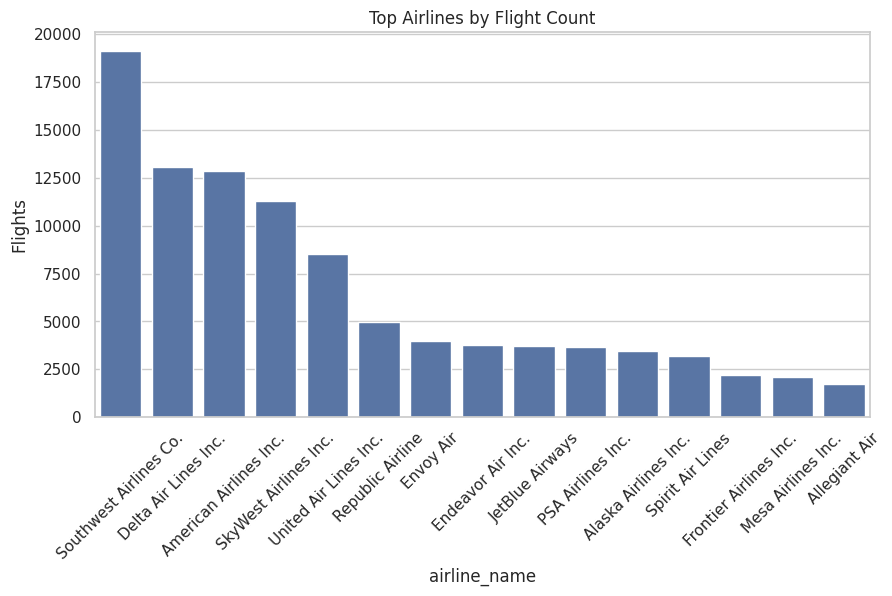

Saved: outputs/dep_delay_hist.png


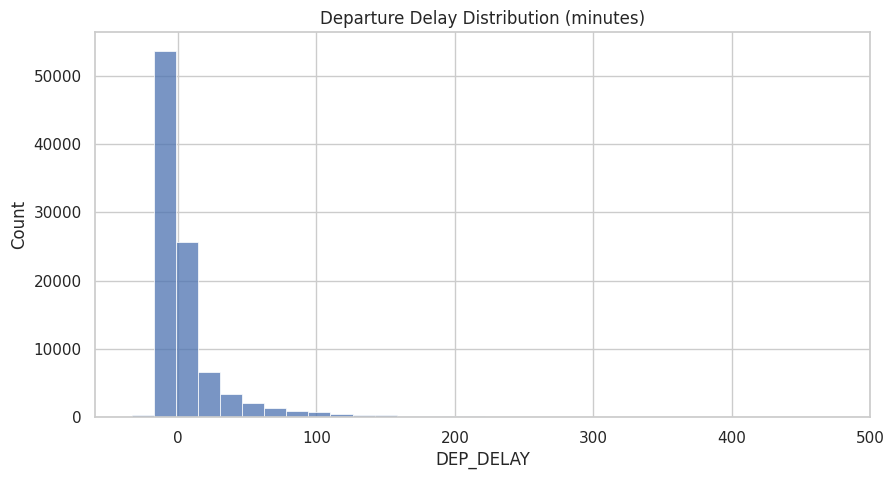

Saved: outputs/top_routes.png


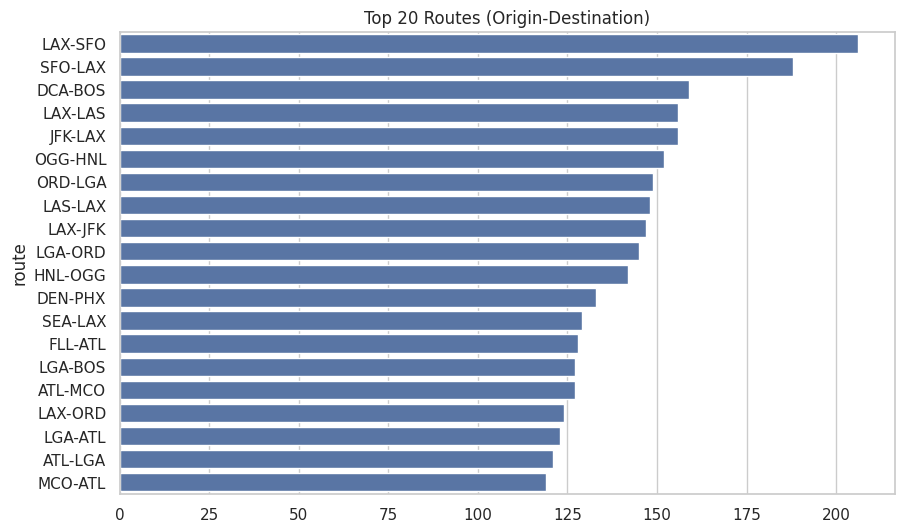

In [15]:
# -----------------------
# STEP 6: Univariate Explorations (counts, top items, histograms)
# -----------------------
# top airlines
if 'airline_name' in df.columns:
    top_air = df['airline_name'].value_counts().head(15)
    fig, ax = plt.subplots(figsize=(10,5))
    sns.barplot(x=top_air.index, y=top_air.values, ax=ax)
    ax.set_title('Top Airlines by Flight Count')
    ax.set_ylabel('Flights')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    savefig(fig, 'top_airlines.png')
    plt.show()

# distribution of departure delays
if col_dep_delay:
    fig, ax = plt.subplots(figsize=(10,5))
    sns.histplot(df[col_dep_delay].dropna(), bins=100, kde=False)
    ax.set_xlim(-60, 500)
    ax.set_title('Departure Delay Distribution (minutes)')
    savefig(fig, 'dep_delay_hist.png')
    plt.show()

# top routes
if 'route' in df.columns:
    top_routes = df['route'].value_counts().head(20)
    fig, ax = plt.subplots(figsize=(10,6))
    sns.barplot(y=top_routes.index, x=top_routes.values, ax=ax)
    ax.set_title('Top 20 Routes (Origin-Destination)')
    savefig(fig, 'top_routes.png')
    plt.show()


/tmp/ipython-input-3700036913.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


Saved: outputs/avg_arr_delay_by_airline.png


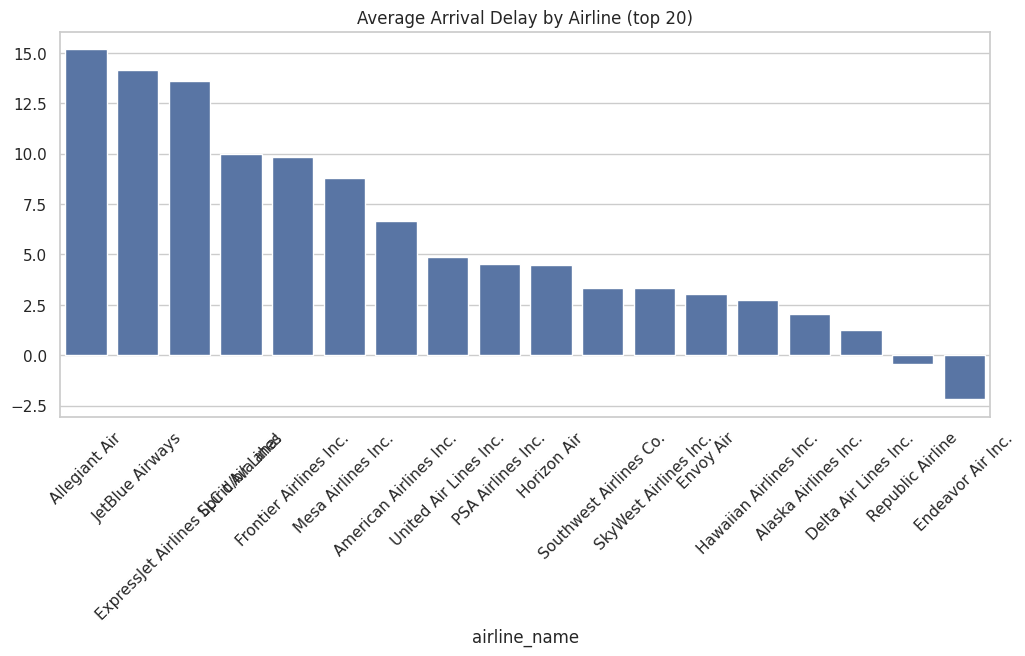

In [16]:
# -----------------------
# STEP 7: Bivariate & Delay Trends
# - Average delay by airline, by hour, by day of week, by month
# -----------------------
# Avg delay by airline
if col_arr_delay and 'airline_name' in df.columns:
    avg_by_air = df.groupby('airline_name')[col_arr_delay].mean().sort_values(ascending=False).head(20)
    fig, ax = plt.subplots(figsize=(12,5))
    sns.barplot(x=avg_by_air.index, y=avg_by_air.values, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_title('Average Arrival Delay by Airline (top 20)')
    savefig(fig, 'avg_arr_delay_by_airline.png')
    plt.show()

# Delay by hour of day
if 'dep_hour' in df.columns and col_dep_delay:
    agg = df.groupby('dep_hour')[col_dep_delay].median()
    fig, ax = plt.subplots(figsize=(10,4))
    sns.lineplot(x=agg.index, y=agg.values, marker='o', ax=ax)
    ax.set_title('Median Departure Delay by Scheduled Hour')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Median Dep Delay (min)')
    savefig(fig, 'median_dep_delay_by_hour.png')
    plt.show()

# Boxplot: delay distribution per day of week (if available)
if 'day_of_week' in df.columns and col_arr_delay:
    order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    fig, ax = plt.subplots(figsize=(12,5))
    sns.boxplot(x='day_of_week', y=col_arr_delay, data=df[df[col_arr_delay].notna() & (df[col_arr_delay]>-120)],
                order=order, ax=ax)
    ax.set_ylim(-60, 600)
    ax.set_title('Arrival Delay by Day of Week (boxplot)')
    savefig(fig, 'arr_delay_by_dayofweek_box.png')
    plt.show()


In [17]:
# -----------------------
# STEP 8: Delay cause analysis (stacked / comparative)
# -----------------------
if delay_cause_cols:
    # sum of delay minutes by cause per airline
    sums = df.groupby('airline_name')[delay_cause_cols].sum().sort_values(by=delay_cause_cols[0], ascending=False).head(20)
    # plot stacked bar (matplotlib)
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)
    bottom = np.zeros(len(sums))
    for c in delay_cause_cols:
        ax.bar(sums.index, sums[c], bottom=bottom, label=c)
        bottom += sums[c].values
    ax.set_xticklabels(sums.index, rotation=45)
    ax.set_title('Stacked Delay Minutes by Cause (Top Airlines)')
    ax.legend()
    savefig(fig, 'stacked_delay_by_cause_airline.png')
    plt.show()
else:
    print("No granular delay-cause columns present; skipping this step.")


No granular delay-cause columns present; skipping this step.


Saved: outputs/cancellation_reasons.png


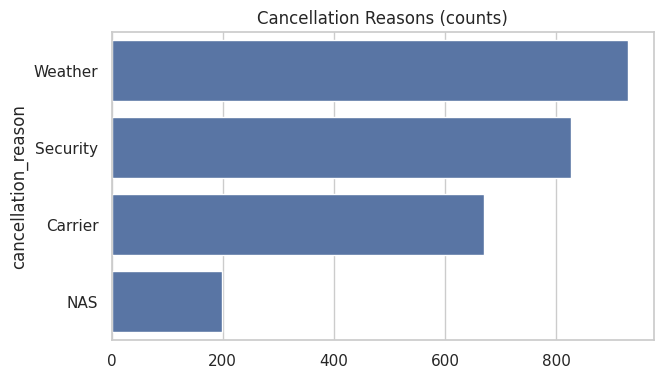

In [18]:
# -----------------------
# STEP 9: Cancellation & Seasonal Trends
# -----------------------
if col_cancelled:
    # monthly cancellation rate (if scheduled_dep exists)
    if 'scheduled_dep' in df.columns:
        monthly = (df.assign(month=df['scheduled_dep'].dt.to_period('M'))
                   .groupby('month')
                   [[col_cancelled]].mean().reset_index())
        monthly['month'] = monthly['month'].dt.to_timestamp()
        fig, ax = plt.subplots(figsize=(10,4))
        sns.lineplot(x=monthly['month'], y=monthly[col_cancelled], marker='o', ax=ax)
        ax.set_title('Monthly Cancellation Rate')
        ax.set_ylabel('Cancellation Rate')
        savefig(fig, 'monthly_cancellation_rate.png')
        plt.show()

    # cancellation reasons
    if 'cancellation_reason' in df.columns:
        reason_counts = df[df[col_cancelled]==1]['cancellation_reason'].value_counts()
        fig, ax = plt.subplots(figsize=(7,4))
        sns.barplot(x=reason_counts.values, y=reason_counts.index, ax=ax)
        ax.set_title('Cancellation Reasons (counts)')
        savefig(fig, 'cancellation_reasons.png')
        plt.show()


Saved: outputs/od_heatmap.png


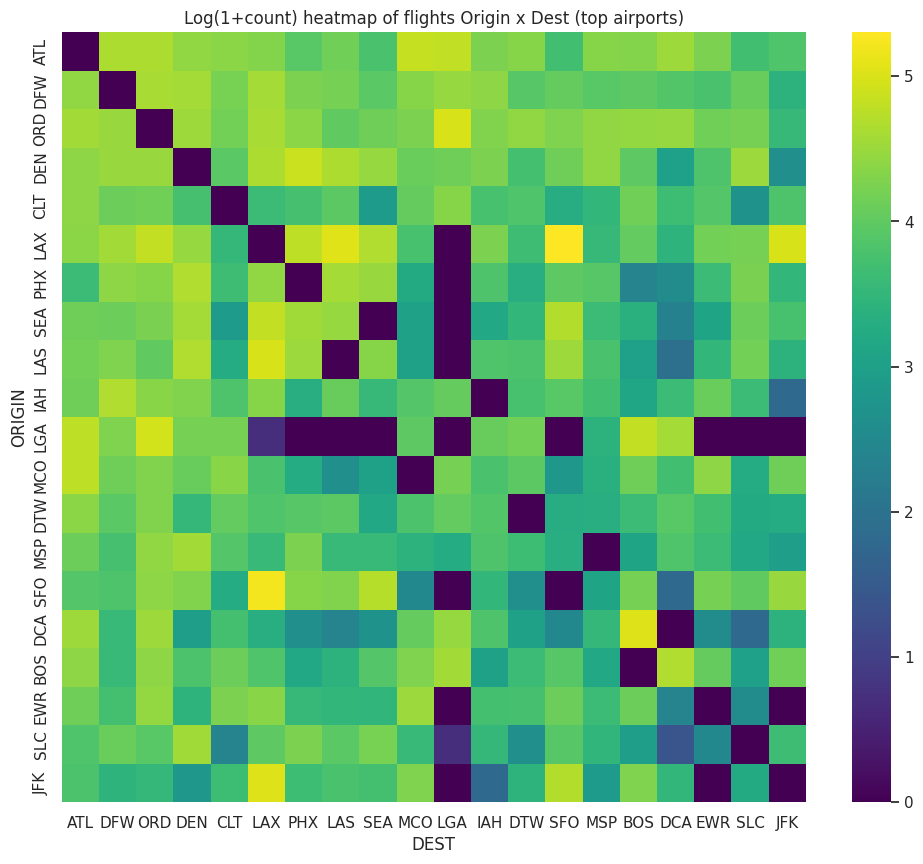

In [19]:
# -----------------------
# STEP 10: Airport & Route-level heatmap (top airports)
# -----------------------
if col_origin and col_dest:
    top_origins = df[col_origin].value_counts().head(30).index.tolist()
    top_dests = df[col_dest].value_counts().head(30).index.tolist()
    subset = df[df[col_origin].isin(top_origins) & df[col_dest].isin(top_dests)]
    pivot = subset.pivot_table(index=col_origin, columns=col_dest, values=col_arr_delay, aggfunc='count', fill_value=0)
    # limit to top 20 for readability
    pivot_small = pivot.loc[top_origins[:20], top_dests[:20]]
    fig, ax = plt.subplots(figsize=(12,10))
    sns.heatmap(np.log1p(pivot_small), cmap='viridis', ax=ax)
    ax.set_title('Log(1+count) heatmap of flights Origin x Dest (top airports)')
    savefig(fig, 'od_heatmap.png')
    plt.show()


In [20]:
# -----------------------
# STEP 11: Simple interactive map of busiest airports (if lat/lon available)
# -----------------------
# Look for lat/lon columns (common names)
lat_col = pick_col(df, ['lat','latitude'])
lon_col = pick_col(df, ['lon','longitude','long'])

if lat_col and lon_col:
    # aggregate airport locations and counts
    airports = df.groupby([col_origin, lat_col, lon_col]).size().reset_index(name='count')
    # center map at mean coord
    m = folium.Map(location=[airports[lat_col].mean(), airports[lon_col].mean()], zoom_start=4)
    for _, row in airports.iterrows():
        folium.CircleMarker(location=[row[lat_col], row[lon_col]],
                            radius=max(3, min(row['count']/100, 20)),
                            popup=f"{row[col_origin]}: {row['count']} flights",
                            fill=True).add_to(m)
    m.save('outputs/busy_airports_map.html')
    print("Saved interactive map to outputs/busy_airports_map.html")
else:
    print("No lat/lon columns found in dataset. If you want maps, merge with an airports coordinates CSV (IATA -> lat/lon).")


No lat/lon columns found in dataset. If you want maps, merge with an airports coordinates CSV (IATA -> lat/lon).


In [21]:
# Importing commonly used libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots look cleaner
sns.set(style="whitegrid")


In [22]:
# Load the dataset from zip file
import zipfile

# Path to dataset (adjust if needed)
zip_path = "flights_sample_100k.csv.zip"

with zipfile.ZipFile(zip_path) as z:
    file_name = [f for f in z.namelist() if f.endswith(".csv")][0]
    df = pd.read_csv(z.open(file_name), low_memory=False)

print("Shape of data:", df.shape)
df.head()


Shape of data: (100000, 32)


,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
0,2019-03-01,Allegiant Air,Allegiant Air: G4,G4,20368,1668,PGD,"Punta Gorda, FL",SPI,"Springfield, IL",630,620.0,-10.0,9.0,629.0,731.0,7.0,810,738.0,-32.0,0.0,NaN,0.0,160.0,138.0,122.0,994.0,NaN,NaN,NaN,NaN,NaN
1,2021-02-16,American Airlines Inc.,American Airlines Inc.: AA,AA,19805,2437,DFW,"Dallas/Fort Worth, TX",LAX,"Los Angeles, CA",1329,NaN,NaN,NaN,NaN,NaN,NaN,1500,NaN,NaN,1.0,B,0.0,211.0,NaN,NaN,1235.0,NaN,NaN,NaN,NaN,NaN
2,2022-04-12,PSA Airlines Inc.,PSA Airlines Inc.: OH,OH,20397,5560,EWN,"New Bern/Morehead/Beaufort, NC",CLT,"Charlotte, NC",625,618.0,-7.0,16.0,634.0,725.0,11.0,744,736.0,-8.0,0.0,NaN,0.0,79.0,78.0,51.0,221.0,NaN,NaN,NaN,NaN,NaN
3,2021-10-13,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,1944,ABQ,"Albuquerque, NM",DEN,"Denver, CO",1715,1740.0,25.0,15.0,1755.0,1844.0,7.0,1835,1851.0,16.0,0.0,NaN,0.0,80.0,71.0,49.0,349.0,10.0,0.0,0.0,0.0,6.0
4,2022-06-05,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,3081,PIT,"Pittsburgh, PA",STL,"St. Louis, MO",535,535.0,0.0,12.0,547.0,609.0,6.0,620,615.0,-5.0,0.0,NaN,0.0,105.0,100.0,82.0,554.0,NaN,NaN,NaN,NaN,NaN


In [23]:
# Check the structure of the dataset
df.info()

# Check missing values
df.isnull().sum().head(20)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 32 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   FL_DATE                  100000 non-null  object 
 1   AIRLINE                  100000 non-null  object 
 2   AIRLINE_DOT              100000 non-null  object 
 3   AIRLINE_CODE             100000 non-null  object 
 4   DOT_CODE                 100000 non-null  int64  
 5   FL_NUMBER                100000 non-null  int64  
 6   ORIGIN                   100000 non-null  object 
 7   ORIGIN_CITY              100000 non-null  object 
 8   DEST                     100000 non-null  object 
 9   DEST_CITY                100000 non-null  object 
 10  CRS_DEP_TIME             100000 non-null  int64  
 11  DEP_TIME                 97424 non-null   float64
 12  DEP_DELAY                97423 non-null   float64
 13  TAXI_OUT                 97382 non-null   float64
 14  WHEEL

,0
FL_DATE,0
AIRLINE,0
AIRLINE_DOT,0
AIRLINE_CODE,0
DOT_CODE,0
FL_NUMBER,0
ORIGIN,0
ORIGIN_CITY,0
DEST,0
DEST_CITY,0


In [24]:
# Remove extra spaces and make column names consistent
df.columns = [c.strip().lower() for c in df.columns]

# Preview the new column names
df.columns


Index(['fl_date', 'airline', 'airline_dot', 'airline_code', 'dot_code',
       'fl_number', 'origin', 'origin_city', 'dest', 'dest_city',
       'crs_dep_time', 'dep_time', 'dep_delay', 'taxi_out', 'wheels_off',
       'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'arr_delay',
       'cancelled', 'cancellation_code', 'diverted', 'crs_elapsed_time',
       'elapsed_time', 'air_time', 'distance', 'delay_due_carrier',
       'delay_due_weather', 'delay_due_nas', 'delay_due_security',
       'delay_due_late_aircraft'],
      dtype='object')

In [25]:
# Create a new route column: ORIGIN -> DEST
df["route"] = df["origin"] + "-" + df["dest"]

# Convert departure delay to numeric
df["dep_delay"] = pd.to_numeric(df["dep_delay"], errors="coerce")

# Create a binary flag for delayed flights (>=15 minutes)
df["is_delayed"] = df["dep_delay"] >= 15

df[["origin", "dest", "route", "dep_delay", "is_delayed"]].head()

,origin,dest,route,dep_delay,is_delayed
0,PGD,SPI,PGD-SPI,-10.0,False
1,DFW,LAX,DFW-LAX,NaN,False
2,EWN,CLT,EWN-CLT,-7.0,False
3,ABQ,DEN,ABQ-DEN,25.0,True
4,PIT,STL,PIT-STL,0.0,False


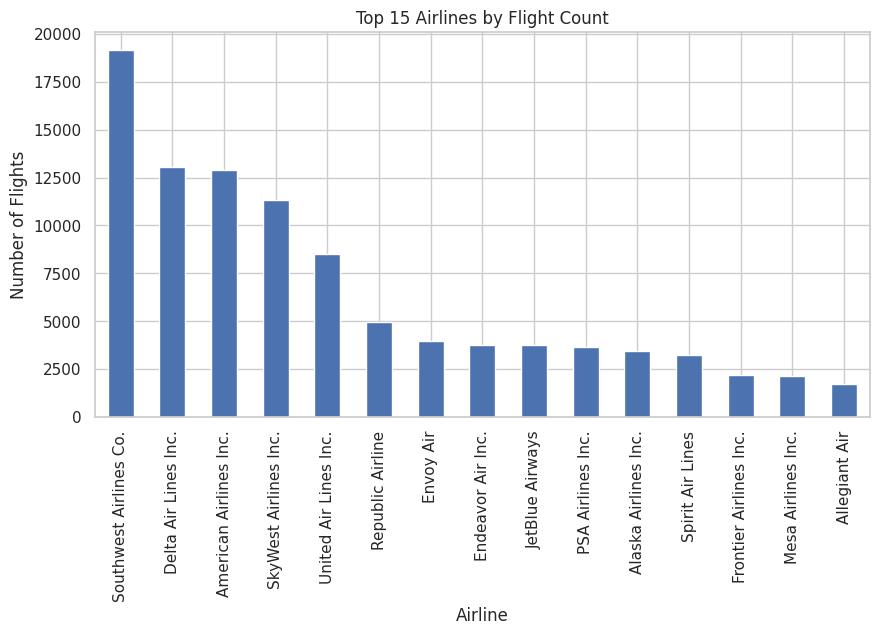

In [26]:
plt.figure(figsize=(10,5))
df["airline"].value_counts().head(15).plot(kind="bar")
plt.title("Top 15 Airlines by Flight Count")
plt.xlabel("Airline")
plt.ylabel("Number of Flights")
plt.show()


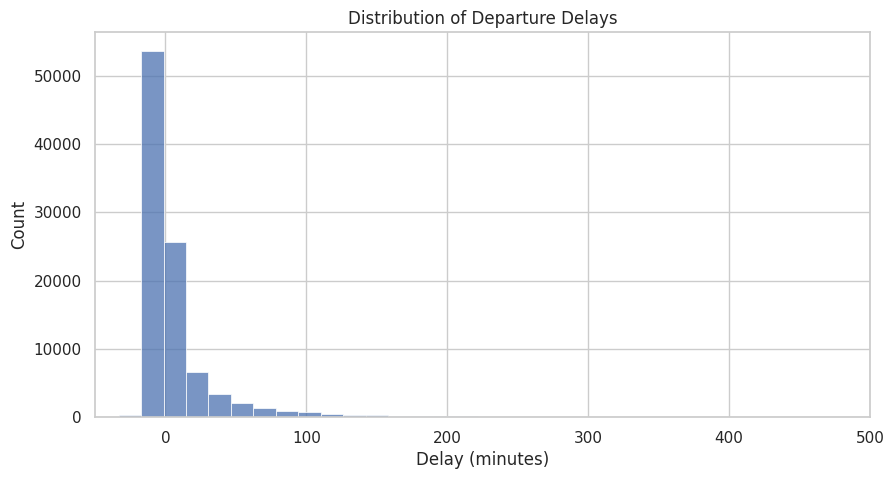

In [27]:
plt.figure(figsize=(10,5))
sns.histplot(df["dep_delay"].dropna(), bins=100, kde=False)
plt.xlim(-50, 500)
plt.title("Distribution of Departure Delays")
plt.xlabel("Delay (minutes)")
plt.ylabel("Count")
plt.show()

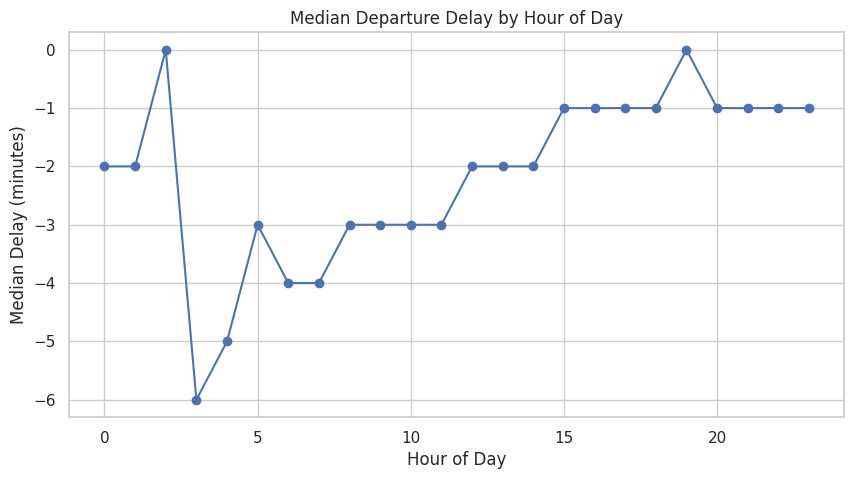

In [28]:
# Extract departure hour
df["crs_dep_time"] = df["crs_dep_time"].astype(str).str.zfill(4)
df["dep_hour"] = df["crs_dep_time"].str[:2].astype(int)

# Median delay per hour
hourly_delay = df.groupby("dep_hour")["dep_delay"].median()

plt.figure(figsize=(10,5))
hourly_delay.plot(marker="o")
plt.title("Median Departure Delay by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Median Delay (minutes)")
plt.show()

Overall cancellation rate: 2.63%


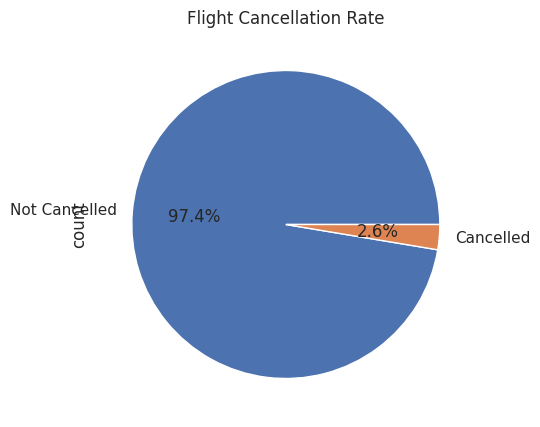

In [29]:
if "cancelled" in df.columns:
    cancel_rate = df["cancelled"].mean() * 100
    print(f"Overall cancellation rate: {cancel_rate:.2f}%")

    plt.figure(figsize=(5,5))
    df["cancelled"].value_counts().plot(kind="pie", autopct="%1.1f%%", labels=["Not Cancelled", "Cancelled"])
    plt.title("Flight Cancellation Rate")
    plt.show()


In [30]:
# Save cleaned dataset for future analysis
df.to_parquet("cleaned_flights.parquet", index=False)
print("Cleaned dataset saved as cleaned_flights.parquet")

Cleaned dataset saved as cleaned_flights.parquet


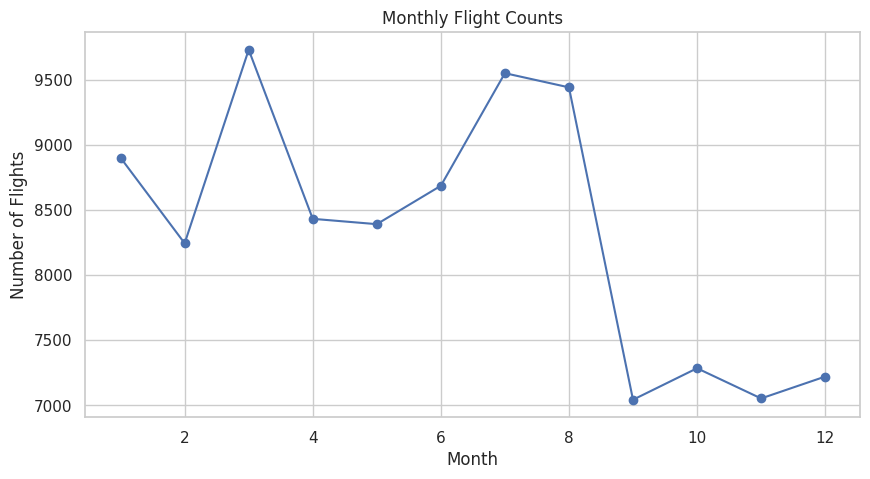

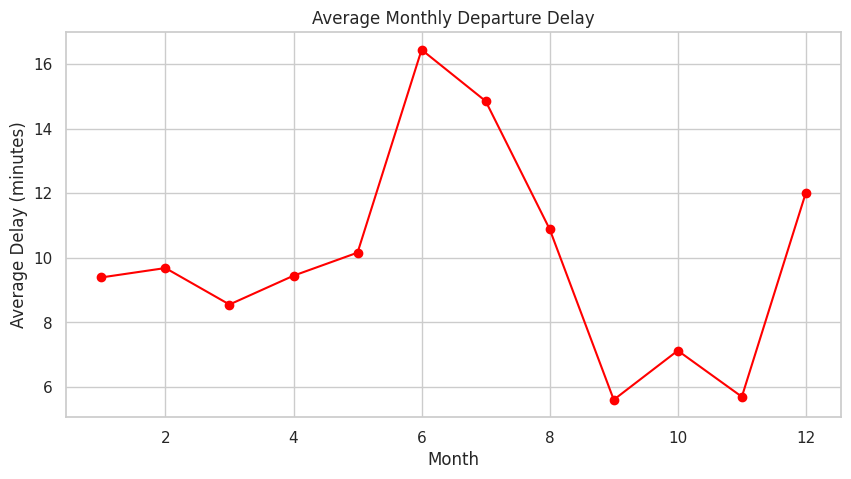

In [33]:
# Flights per month
# Convert 'fl_date' to datetime and extract month
df['fl_date'] = pd.to_datetime(df['fl_date'])
df['month'] = df['fl_date'].dt.month

monthly_flights = df.groupby("month")["fl_number"].count()

plt.figure(figsize=(10,5))
monthly_flights.plot(marker="o")
plt.title("Monthly Flight Counts")
plt.xlabel("Month")
plt.ylabel("Number of Flights")
plt.show()

# Average monthly delay
monthly_delay = df.groupby("month")["dep_delay"].mean()

plt.figure(figsize=(10,5))
monthly_delay.plot(marker="o", color="red")
plt.title("Average Monthly Departure Delay")
plt.xlabel("Month")
plt.ylabel("Average Delay (minutes)")
plt.show()

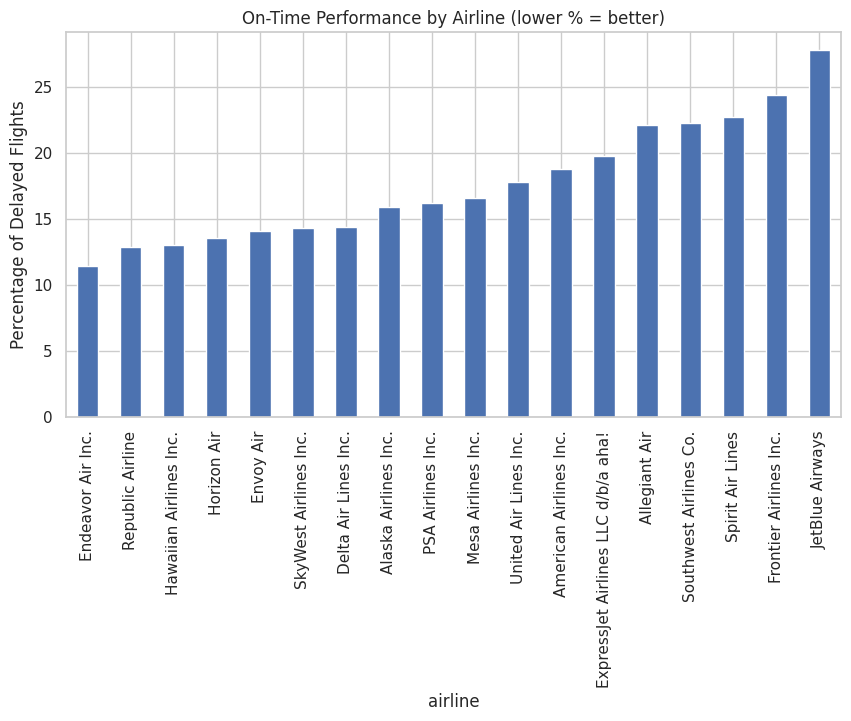

In [34]:
# On-time performance by airline
airline_performance = df.groupby("airline")["is_delayed"].mean() * 100

plt.figure(figsize=(10,5))
airline_performance.sort_values().plot(kind="bar")
plt.title("On-Time Performance by Airline (lower % = better)")
plt.ylabel("Percentage of Delayed Flights")
plt.show()


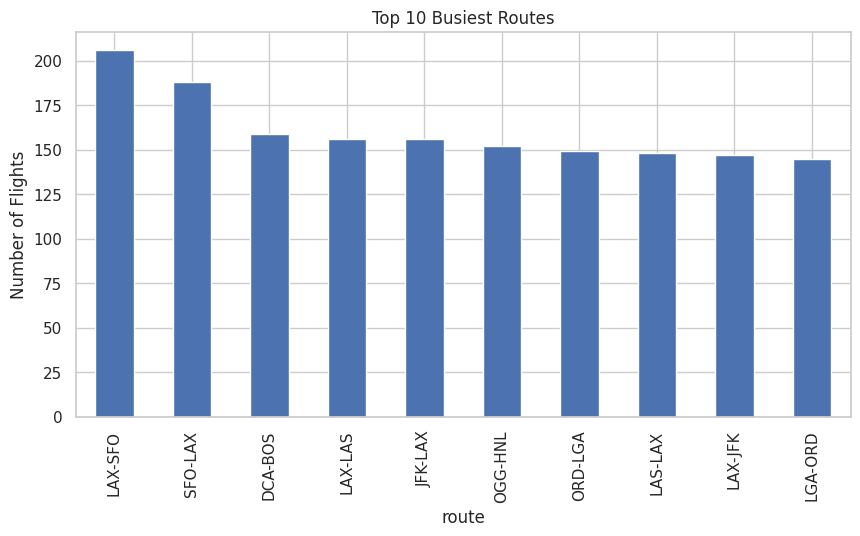

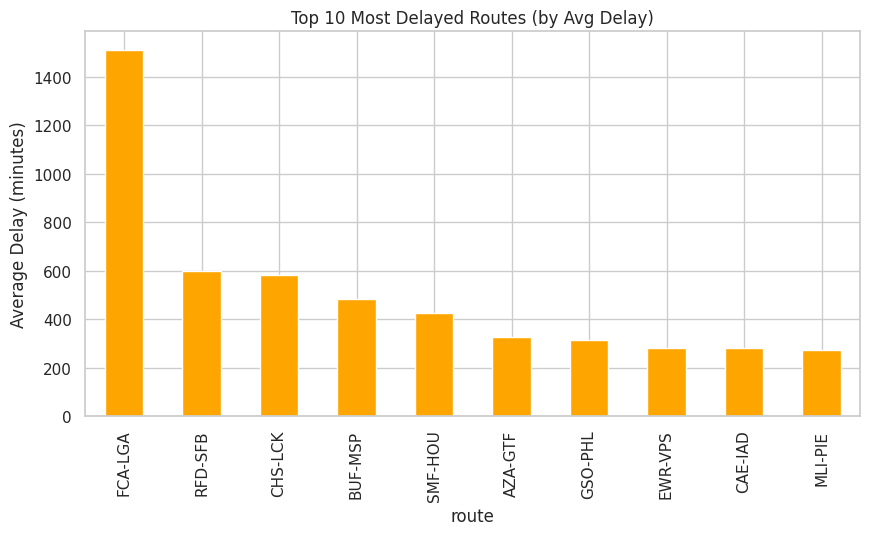

In [36]:
# Top 10 busiest routes
top_routes = df["route"].value_counts().head(10)

plt.figure(figsize=(10,5))
top_routes.plot(kind="bar")
plt.title("Top 10 Busiest Routes")
plt.ylabel("Number of Flights")
plt.show()

# Top 10 most delayed routes
avg_route_delay = df.groupby("route")["dep_delay"].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
avg_route_delay.plot(kind="bar", color="orange")
plt.title("Top 10 Most Delayed Routes (by Avg Delay)")
plt.ylabel("Average Delay (minutes)")
plt.show()

Delay cause columns found: ['dep_delay', 'arr_delay', 'delay_due_carrier', 'delay_due_weather', 'delay_due_nas', 'delay_due_security', 'delay_due_late_aircraft', 'is_delayed']


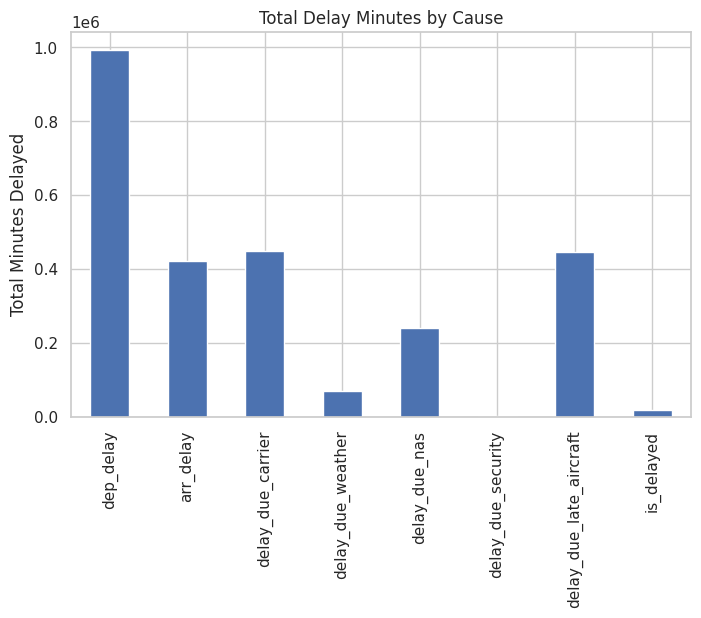

In [43]:
# Check if cause columns exist
cause_cols = [c for c in df.columns if "delay" in c and c not in ["depdelay", "arrdelay"]]
print("Delay cause columns found:", cause_cols)

if cause_cols:
    cause_sums = df[cause_cols].sum()

    plt.figure(figsize=(8,5))
    cause_sums.plot(kind="bar")
    plt.title("Total Delay Minutes by Cause")
    plt.ylabel("Total Minutes Delayed")
    plt.show()


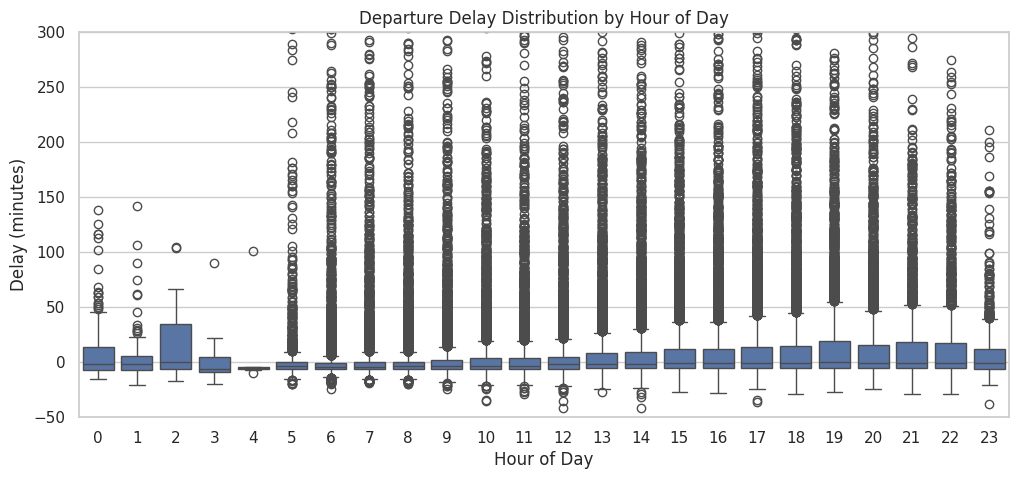

In [39]:
# Delay by hour of day (boxplot)
plt.figure(figsize=(12,5))
sns.boxplot(x="dep_hour", y="dep_delay", data=df)
plt.title("Departure Delay Distribution by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Delay (minutes)")
plt.ylim(-50, 300)
plt.show()

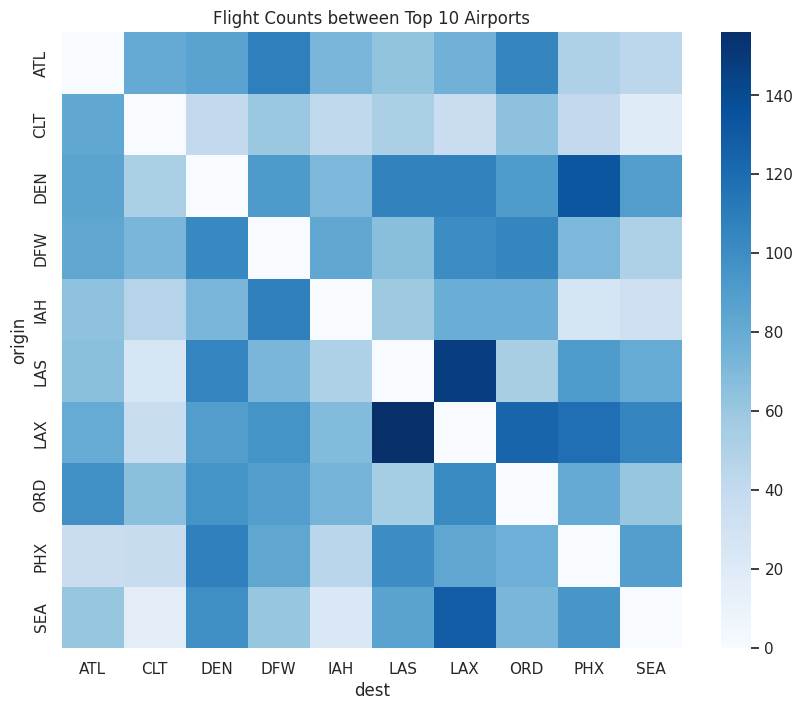

In [40]:
# Create OD matrix for top airports
top_airports = df["origin"].value_counts().head(10).index
od_matrix = pd.crosstab(df[df["origin"].isin(top_airports)]["origin"],
                        df[df["dest"].isin(top_airports)]["dest"])

plt.figure(figsize=(10,8))
sns.heatmap(od_matrix, annot=False, cmap="Blues")
plt.title("Flight Counts between Top 10 Airports")
plt.show()


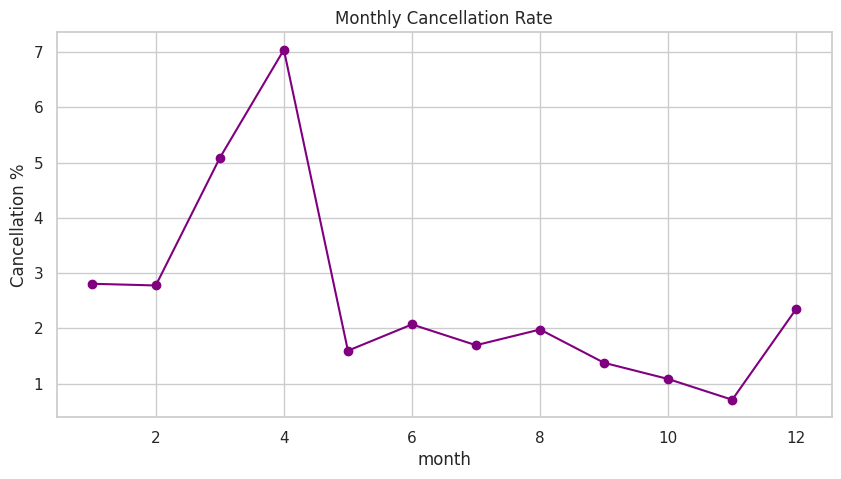

In [41]:
if "cancelled" in df.columns and "month" in df.columns:
    monthly_cancels = df.groupby("month")["cancelled"].mean() * 100

    plt.figure(figsize=(10,5))
    monthly_cancels.plot(marker="o", color="purple")
    plt.title("Monthly Cancellation Rate")
    plt.ylabel("Cancellation %")
    plt.show()


In [42]:
# Predict if a flight will be delayed using simple Logistic Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Features: airline, dep_hour, month
ml_df = df.dropna(subset=["is_delayed", "dep_hour", "month", "airline"])

X = pd.get_dummies(ml_df[["airline", "dep_hour", "month"]], drop_first=True)
y = ml_df["is_delayed"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Model Performance:\n")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))


Model Performance:

              precision    recall  f1-score   support

           0       0.82      1.00      0.90     24640
           1       0.00      0.00      0.00      5360

    accuracy                           0.82     30000
   macro avg       0.41      0.50      0.45     30000
weighted avg       0.67      0.82      0.74     30000


Confusion Matrix:

[[24640     0]
 [ 5360     0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
